# LAND USE 02: ANALYZING 2012 LAND USE & 2012 WATER QUALITY

# 01) IMPORT RAW DATA

In [1]:
import math
import pandas as pd
import scipy.stats as stats
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# lookup table: county codes (from http://bit.ly/F7XW4J1JDataset0)
strCounty = 'F7XW4J1J (Anthropogenic Influences)/Dataset0_Boundary_IDs/boundary_ids-counties.txt'
# lookup table: state FIPS (from https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code)
strFIPS = 'F7XW4J1J (Anthropogenic Influences)/StateFIPS.csv'
# lookup table: NAWQA Wall-to-Wall Anthropogenic Landuse Trends (NWALT) fields (from http://bit.ly/F7XW4J1JDataset8)
strNWALT = 'F7XW4J1J (Anthropogenic Influences)/NWALT.csv'

In [3]:
# import lookup tables
dfCounty = pd.read_csv(strCounty)
dfFIPS = pd.read_csv(strFIPS)
dfNWALT = pd.read_csv(strNWALT)

In [4]:
# define paths to source files (from http://bit.ly/F7XW4J1JDataset8) & import
strLand2012 = 'F7XW4J1J (Anthropogenic Influences)/Dataset8_LandUse/landuse-county-nwalt2012.txt'
dfLand2012 = pd.read_csv(strLand2012)
strWQI2012 = 'WQI2012.csv'
dfWQI2012 = pd.read_csv(strWQI2012)

# 02) REFORMAT DATA

In [5]:
# County dataframe: create new col to capture 5-digit state & county GEOID
dfCounty['GEOID5'] = ''
dfCounty['GEOID5'] = dfCounty['GEOID10'].astype('object')
# prepend four-digit GEOID5s with a zero
dfCounty['GEOID5'] = dfCounty['GEOID5'].apply(lambda x: str(x).zfill(5))
dfCounty['FIPS'] = dfCounty['GEOID5'].apply(lambda x: str(x)[:2])
# drop GEOID10
dfCounty = dfCounty.drop('GEOID10', axis=1)

In [6]:
# FIPS dataframe: format FIPS column as two-digit string
dfFIPS['FIPS'] = dfFIPS['FIPS'].astype('str')
for index, var in enumerate(dfFIPS['FIPS']):
    if float(var) < 10:
        dfFIPS.loc[index, 'FIPS'] = '0' + str(var)

In [7]:
# NWALT dataframe: ensure Classes are strings
dfNWALT['Class'] = dfNWALT['Class'].astype('str')

In [8]:
# define function to rename Land Use cols
def RenameCols(df, strYr):
    dictColNm = {'uniqid_county':'uniqid_co'}
    for index, row in dfNWALT.iterrows():
        dictColNm['NWALT' + strYr + '_' + dfNWALT.loc[index,'Class'] + '_county'] = \
            strYr + dfNWALT.loc[index,'Defn']
    df = df.rename(columns=dictColNm)
    return df

In [9]:
# call Rename Columns() to give dataframes English names
dfLand2012 = RenameCols(dfLand2012, '12')

# 03) CREATE MASTER DATAFRAME & COMPUTE DIFFS

In [10]:
# create master dataframe df2012
df2012 = pd.merge(dfLand2012, dfCounty, on='uniqid_co')
df2012 = pd.merge(df2012, dfFIPS, on='FIPS')

In [11]:
df2012['FIPS Code'] = df2012['GEOID5'].astype(float)

In [12]:
df2012 = pd.merge(df2012, dfWQI2012, on='FIPS Code')

In [13]:
df2012.columns

Index(['uniqid_co', '12Water', '12Wetlands', '12Dev-Trans', '12Dev-CommSvcs',
       '12Dev-IndMil', '12Dev-Recr', '12Dev-ResHi', '12Dev-ResLoMed',
       '12Dev-Other', '12SemiDev-UrbIntHi', '12SemiDev-UrbIntLoMed',
       '12SemiDev-Other', '12Mining', '12Crops', '12Pasture', '12Grazing1',
       '12Grazing2', '12LowUse', '12VeryLowUse', '12Unknown', 'NAMELSAD10',
       'areakm2', 'GEOID5', 'FIPS', 'State', 'St', 'FIPS Code', 'Unnamed: 0',
       'StateCode', 'CountyCode', 'Mean_pH', 'Mean Turbidity',
       'Mean Fecal Coliform', 'Mean Fecal Coliform Fill', 'Mean_pH Fill',
       'Mean Turbidity Fill', 'WQIFill', 'WQI'],
      dtype='object')

In [14]:
df2012=df2012.dropna(subset=['WQI'], thresh=1)

In [15]:
# create format strings to prettify output
strFmt = '{:,.3f}'
strFmtSignSpc = '{:+1,.3f}'
strFmtSpc = '{: ,.3f}'
# compute regressions against each var
for col in df2012.filter(regex='12').columns:
    slope, intercept, r_value, p_value, std_err=stats.linregress(df2012[col], df2012['WQI'])
    strMX = f'{strFmtSpc.format(slope).rjust(7)} × {col.ljust(21)}'
    strB = f'{strFmtSignSpc.format(intercept)}'
    strPAndR2 = f'P = {strFmt.format(p_value)}, R² = {strFmtSignSpc.format(r_value**2)}'
    # if not math.isnan(slope):
    print(f'WQI = {strB} + {strMX} | {strPAndR2}')

WQI = +71.914 +   0.152 × 12Water               | P = 0.119, R² = +0.001
WQI = +72.830 +  -0.151 × 12Wetlands            | P = 0.000, R² = +0.009
WQI = +72.852 +  -0.604 × 12Dev-Trans           | P = 0.001, R² = +0.004
WQI = +72.582 +  -0.323 × 12Dev-CommSvcs        | P = 0.003, R² = +0.004
WQI = +72.621 +  -0.749 × 12Dev-IndMil          | P = 0.000, R² = +0.005
WQI = +72.465 +  -0.532 × 12Dev-Recr            | P = 0.038, R² = +0.002
WQI = +72.415 +  -0.139 × 12Dev-ResHi           | P = 0.024, R² = +0.002
WQI = +72.638 +  -0.161 × 12Dev-ResLoMed        | P = 0.011, R² = +0.003
WQI = +71.449 +   1.325 × 12Dev-Other           | P = 0.064, R² = +0.001
WQI = +72.390 +  -0.180 × 12SemiDev-UrbIntHi    | P = 0.082, R² = +0.001
WQI = +72.502 +  -0.056 × 12SemiDev-UrbIntLoMed | P = 0.117, R² = +0.001
WQI = +72.236 +   0.121 × 12SemiDev-Other       | P = 0.977, R² = +0.000
WQI = +72.024 +   1.897 × 12Mining              | P = 0.030, R² = +0.002
WQI = +73.875 +  -0.076 × 12Crops               | P

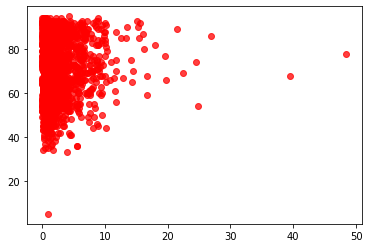

In [16]:
plt.scatter(df2012['12Water'], df2012['WQI'], marker='o', facecolors='red', alpha=0.75)

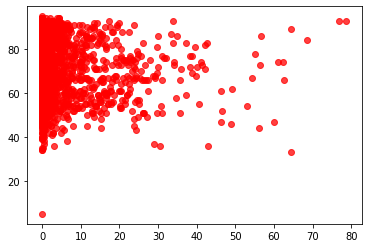

In [17]:
plt.scatter(df2012['12Wetlands'], df2012['WQI'], marker='o', facecolors='red', alpha=0.75)

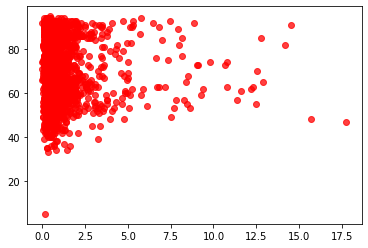

In [18]:
plt.scatter(df2012['12Dev-Trans'], df2012['WQI'], marker='o', facecolors='red', alpha=0.75)

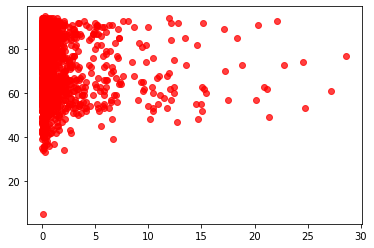

In [19]:
plt.scatter(df2012['12Dev-CommSvcs'], df2012['WQI'], marker='o', facecolors='red', alpha=0.75)

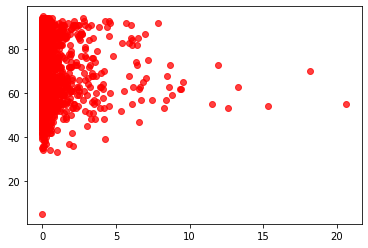

In [20]:
plt.scatter(df2012['12Dev-IndMil'], df2012['WQI'], marker='o', facecolors='red', alpha=0.75)

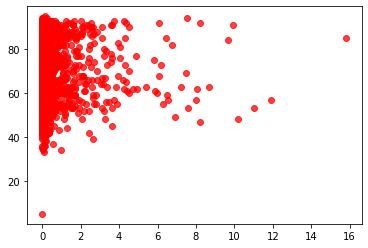

In [21]:
plt.scatter(df2012['12Dev-Recr'], df2012['WQI'], marker='o', facecolors='red', alpha=0.75)

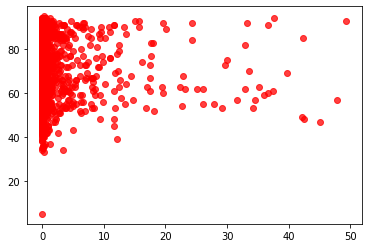

In [22]:
plt.scatter(df2012['12Dev-ResHi'], df2012['WQI'], marker='o', facecolors='red', alpha=0.75)

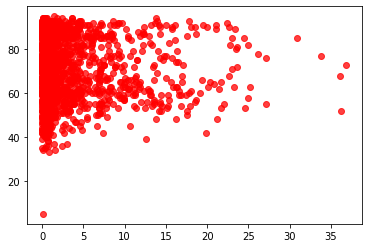

In [23]:
plt.scatter(df2012['12Dev-ResLoMed'], df2012['WQI'], marker='o', facecolors='red', alpha=0.75)

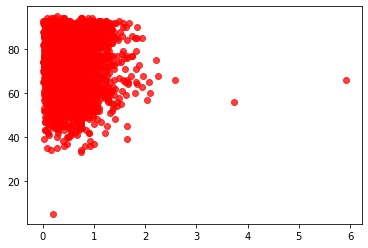

In [24]:
plt.scatter(df2012['12Dev-Other'], df2012['WQI'], marker='o', facecolors='red', alpha=0.75)

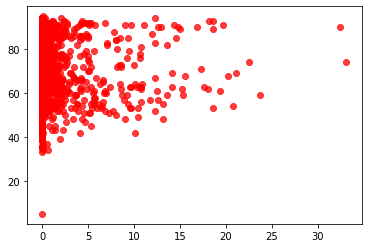

In [25]:
plt.scatter(df2012['12SemiDev-UrbIntHi'], df2012['WQI'], marker='o', facecolors='red', alpha=0.75)

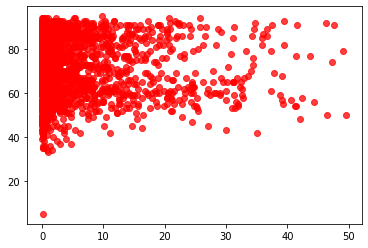

In [26]:
plt.scatter(df2012['12SemiDev-UrbIntLoMed'], df2012['WQI'], marker='o', facecolors='red', alpha=0.75)

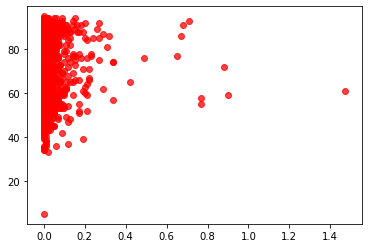

In [27]:
plt.scatter(df2012['12SemiDev-Other'], df2012['WQI'], marker='o', facecolors='red', alpha=0.75)

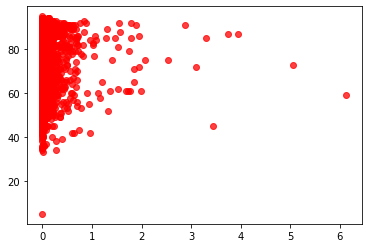

In [28]:
plt.scatter(df2012['12Mining'], df2012['WQI'], marker='o', facecolors='red', alpha=0.75)

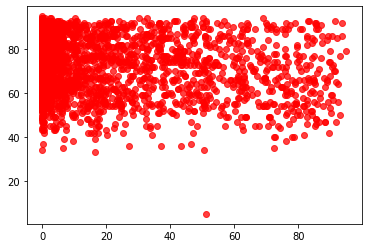

In [29]:
plt.scatter(df2012['12Crops'], df2012['WQI'], marker='o', facecolors='red', alpha=0.75)

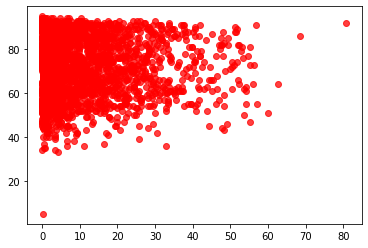

In [30]:
plt.scatter(df2012['12Pasture'], df2012['WQI'], marker='o', facecolors='red', alpha=0.75)

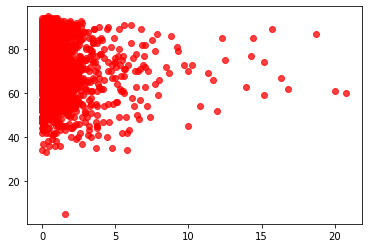

In [31]:
plt.scatter(df2012['12Grazing1'], df2012['WQI'], marker='o', facecolors='red', alpha=0.75)

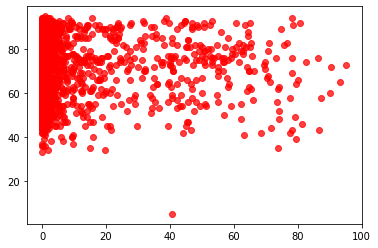

In [32]:
plt.scatter(df2012['12Grazing2'], df2012['WQI'], marker='o', facecolors='red', alpha=0.75)

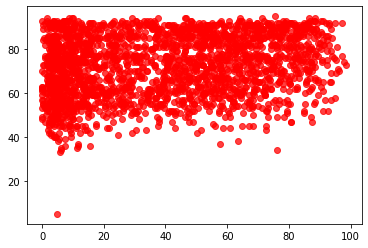

In [33]:
plt.scatter(df2012['12LowUse'], df2012['WQI'], marker='o', facecolors='red', alpha=0.75)

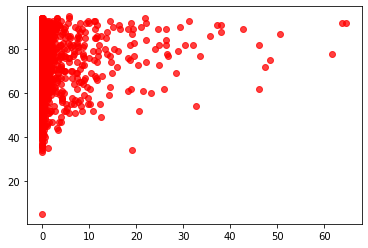

In [34]:
plt.scatter(df2012['12VeryLowUse'], df2012['WQI'], marker='o', facecolors='red', alpha=0.75)

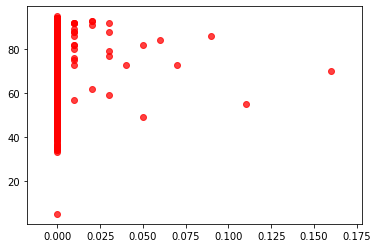

In [35]:
plt.scatter(df2012['12Unknown'], df2012['WQI'], marker='o', facecolors='red', alpha=0.75)